In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.adv_model import *
from lib.dknn_attack import DKNNAttack
from lib.cwl2_attack import CWL2Attack
from lib.dknn import DKNN, DKNNL2
from lib.utils import *

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
exp_id = 6

# model_name = 'train_mnist_exp%d.h5' % exp_id
# net = BasicModel()

model_name = 'train_mnist_snnl_exp%d.h5' % exp_id
net = SNNLModel(train_it=True)

# model_name = 'train_mnist_hidden_mixup_exp%d.h5' % exp_id
# net = HiddenMixupModel()

# model_name = 'train_mnist_vae_exp%d.h5' % exp_id
# net = VAE((1, 28, 28), num_classes=10, latent_dim=20)
# net = VAE2((1, 28, 28), num_classes=10, latent_dim=1000)

# model_name = 'train_mnist_cav_exp%d.h5' % exp_id
# net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)

# model_name = 'adv_mnist_exp%d.h5' % exp_id
# # basic_net = BasicModel()
# basic_net = BasicModelV2()
# config = {'epsilon': 0.3,
#               'num_steps': 40,
#               'step_size': 0.01,
#               'random_start': True,
#               'loss_func': 'xent'}
# net = PGDModel(basic_net, config)

In [18]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
net.eval()

SNNLModel(
  (conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [5]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [6]:
y_pred = net(x_test.to(device))

In [7]:
(y_pred.argmax(1).cpu() == y_test).sum().numpy() / y_test.size(0)

0.9872

In [7]:
# x_train = x_train.to(device)
# x_test = x_test.to(device)
# x_valid = x_valid.to(device)

In [19]:
# layers = ['relu1', 'relu2', 'relu3', 'fc']
# layers = ['relu1', 'relu2', 'relu3']
layers = ['relu3']
# layers = ['fc2']
# layers = ['en_conv3']
# layers = ['en_mu']
# layers = ['maxpool1', 'maxpool2', 'relu3', 'fc2']
# layers = ['maxpool2']

# with torch.no_grad():
#     dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
#                 k=75, num_classes=10)
#     y_pred = dknn.classify(x_test)
    
with torch.no_grad():
    dknn = DKNNL2(net, x_train, y_train, x_valid, y_valid, layers, 
                  k=75, num_classes=10)
    y_pred = dknn.classify(x_test)

In [20]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.9935

In [8]:
cred = dknn.credibility(y_pred)

(array([ 954.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        9046.]),
 array([0.00733333, 0.1066    , 0.20586667, 0.30513333, 0.4044    ,
        0.50366667, 0.60293333, 0.7022    , 0.80146667, 0.90073333,
        1.        ]),
 <a list of 10 Patch objects>)

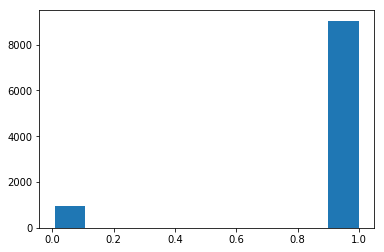

In [9]:
plt.hist(cred)

In [10]:
correct = np.argmax(y_pred, 1) == y_test.numpy()
num_correct_by_cred = np.zeros((10, ))
num_cred = np.zeros((10, ))
for i in np.arange(10):
    ind = (cred > i * 0.1) & (cred <= i* 0.1 + 0.1)
    num_cred[i] = np.sum(ind)
    num_correct_by_cred[i] = np.sum(correct[ind])

<BarContainer object of 10 artists>

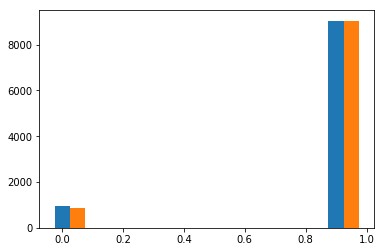

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(10) * 0.1, num_cred, width=0.05)
ax.bar(np.arange(10) * 0.1 + 0.05, num_correct_by_cred, width=0.05)

In [58]:
num_correct_by_cred / num_cred

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.66749689, 0.94009662, 0.97647059, 0.99640546,        nan,
              nan,        nan,        nan,        nan, 0.99950747])

In [45]:
dknn.A.mean()

0.17333333333333334

In [154]:
nn = dknn.get_neighbors(x_valid)

In [15]:
for (D, I) in nn:
    print(D[-1].mean())

0.72602546
0.6874378
0.7105881
0.94844836


## PGD Attack

In [17]:
x_test_np = x_test.cpu().numpy()
y_test_np = y_test.numpy()

In [18]:
model = foolbox.models.PyTorchModel(net, bounds=(0, 1), num_classes=10)

In [ ]:
criterion = foolbox.criteria.Misclassification()
distance = foolbox.distances.Linfinity

attack = foolbox.attacks.RandomPGD(
    model, criterion=criterion, distance=distance)

def attack_wrap(x, y):
    return attack(x, y, binary_search=False, epsilon=0.3, 
                  stepsize=0.01, iterations=300, 
                  random_start=True, return_early=True)

x_adv = np.zeros_like(x_test_np)
for i, (x, y) in enumerate(zip(x_test_np, y_test_np)):
    x_adv[i] = attack_wrap(x, y)

In [ ]:
with torch.no_grad():
    x_adv = torch.tensor(x_adv).to(device)
    y_pred = net(x_adv).detach().cpu().numpy()
np.mean(np.argmax(y_pred, 1) == y_test)

In [29]:
from lib.pgd_attack import PGDAttack

attack = PGDAttack()
x_adv = attack(net, x_test.cuda(), y_test.to(device),
               targeted=False, epsilon=0.01, max_epsilon=0.3,
               max_iterations=300, num_restart=10, rand_start=True)

number of successful adv: 820/10000


In [30]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test).sum().item()

9180

In [31]:
y_pred = dknn.classify(x_adv.cpu())
(y_pred.argmax(1) == y_test.numpy()).sum()

NameError: name 'dknn' is not defined

(array([9.63e+03, 2.96e+02, 5.70e+01, 7.00e+00, 5.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 4.00e+00]),
 array([0.00383333, 0.10345   , 0.20306667, 0.30268333, 0.4023    ,
        0.50191667, 0.60153333, 0.70115   , 0.80076667, 0.90038333,
        1.        ]),
 <a list of 10 Patch objects>)

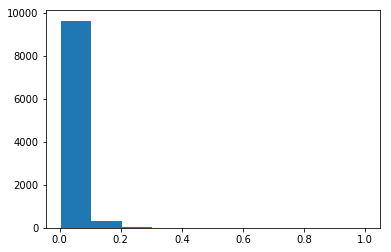

In [55]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [11]:
np.mean(y_pred == y_test)

0.9091

## DkNN Attack

In [21]:
# attack = DKNNAttack()

from lib.dknn_attack_l2 import DKNNL2Attack
attack = DKNNL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            dknn, x[begin:end], y[begin:end],
            guide_layer=layers[0], m=100, binary_search_steps=10,
            max_iterations=500, learning_rate=1e-2,
            initial_const=1e-3, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000], 100)

    step: 0; loss: 104.801; l2dist: 0.000
    step: 50; loss: 87.044; l2dist: 1.345
    step: 100; loss: 75.761; l2dist: 2.201
    step: 150; loss: 67.985; l2dist: 2.782
    step: 200; loss: 65.020; l2dist: 3.011
    step: 250; loss: 63.843; l2dist: 3.052
    step: 300; loss: 59.407; l2dist: 2.985
    step: 350; loss: 54.431; l2dist: 2.774
    step: 400; loss: 52.555; l2dist: 2.665
    step: 450; loss: 51.812; l2dist: 2.609
tensor(96., device='cuda:0')
binary step: 0; number of successful adv: 96/100
    step: 0; loss: 97.195; l2dist: 0.000
    step: 50; loss: 83.103; l2dist: 1.243
    step: 100; loss: 73.295; l2dist: 1.903
    step: 150; loss: 64.999; l2dist: 2.332
    step: 200; loss: 61.220; l2dist: 2.482
    step: 250; loss: 58.997; l2dist: 2.526
    step: 300; loss: 55.785; l2dist: 2.519
    step: 350; loss: 51.418; l2dist: 2.385
    step: 400; loss: 48.985; l2dist: 2.270
    step: 450; loss: 47.890; l2dist: 2.226
tensor(87., device='cuda:0')
binary step: 1; number of successful a

    step: 150; loss: 24.979; l2dist: 1.698
    step: 200; loss: 24.490; l2dist: 1.779
    step: 250; loss: 24.315; l2dist: 1.802
    step: 300; loss: 23.790; l2dist: 1.806
    step: 350; loss: 21.854; l2dist: 1.764
    step: 400; loss: 20.295; l2dist: 1.732
    step: 450; loss: 19.636; l2dist: 1.696
tensor(46., device='cuda:0')
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 32.204; l2dist: 0.000
    step: 50; loss: 28.172; l2dist: 1.019
    step: 100; loss: 26.177; l2dist: 1.426
    step: 150; loss: 24.781; l2dist: 1.699
    step: 200; loss: 24.325; l2dist: 1.779
    step: 250; loss: 24.150; l2dist: 1.799
    step: 300; loss: 23.671; l2dist: 1.800
    step: 350; loss: 21.726; l2dist: 1.761
    step: 400; loss: 20.162; l2dist: 1.732
    step: 450; loss: 19.513; l2dist: 1.696
tensor(51., device='cuda:0')
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 32.219; l2dist: 0.000
    step: 50; loss: 28.189; l2dist: 1.020
    step: 100; loss: 26.196; l2

    step: 300; loss: 37.068; l2dist: 2.010
    step: 350; loss: 34.463; l2dist: 1.976
    step: 400; loss: 32.398; l2dist: 1.939
    step: 450; loss: 31.559; l2dist: 1.884
tensor(68., device='cuda:0')
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 43.569; l2dist: 0.000
    step: 50; loss: 38.057; l2dist: 0.997
    step: 100; loss: 34.618; l2dist: 1.393
    step: 150; loss: 32.201; l2dist: 1.680
    step: 200; loss: 31.276; l2dist: 1.780
    step: 250; loss: 30.728; l2dist: 1.811
    step: 300; loss: 29.587; l2dist: 1.817
    step: 350; loss: 27.425; l2dist: 1.784
    step: 400; loss: 26.091; l2dist: 1.742
    step: 450; loss: 25.287; l2dist: 1.745
tensor(45., device='cuda:0')
binary step: 3; number of successful adv: 100/100
    step: 0; loss: 39.313; l2dist: 0.000
    step: 50; loss: 34.456; l2dist: 1.009
    step: 100; loss: 31.638; l2dist: 1.416
    step: 150; loss: 29.668; l2dist: 1.713
    step: 200; loss: 28.986; l2dist: 1.812
    step: 250; loss: 28.631; l2

    step: 450; loss: 20.099; l2dist: 1.600
tensor(51., device='cuda:0')
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 32.723; l2dist: 0.000
    step: 50; loss: 28.486; l2dist: 0.990
    step: 100; loss: 26.370; l2dist: 1.364
    step: 150; loss: 24.870; l2dist: 1.604
    step: 200; loss: 24.429; l2dist: 1.665
    step: 250; loss: 24.260; l2dist: 1.682
    step: 300; loss: 23.753; l2dist: 1.688
    step: 350; loss: 22.027; l2dist: 1.658
    step: 400; loss: 20.778; l2dist: 1.630
    step: 450; loss: 20.197; l2dist: 1.607
tensor(99., device='cuda:0')
binary step: 9; number of successful adv: 100/100
    step: 0; loss: 100.974; l2dist: 0.000
    step: 50; loss: 82.485; l2dist: 1.382
    step: 100; loss: 72.203; l2dist: 2.217
    step: 150; loss: 65.649; l2dist: 2.735
    step: 200; loss: 63.208; l2dist: 2.943
    step: 250; loss: 62.018; l2dist: 3.002
    step: 300; loss: 57.753; l2dist: 2.951
    step: 350; loss: 53.209; l2dist: 2.724
    step: 400; loss: 51.476; l

    step: 50; loss: 33.357; l2dist: 1.028
    step: 100; loss: 30.724; l2dist: 1.456
    step: 150; loss: 28.960; l2dist: 1.771
    step: 200; loss: 28.417; l2dist: 1.860
    step: 250; loss: 28.145; l2dist: 1.892
    step: 300; loss: 27.412; l2dist: 1.902
    step: 350; loss: 25.386; l2dist: 1.866
    step: 400; loss: 23.807; l2dist: 1.816
    step: 450; loss: 23.057; l2dist: 1.778
tensor(51., device='cuda:0')
binary step: 5; number of successful adv: 100/100
    step: 0; loss: 38.286; l2dist: 0.000
    step: 50; loss: 33.393; l2dist: 1.026
    step: 100; loss: 30.771; l2dist: 1.455
    step: 150; loss: 28.996; l2dist: 1.769
    step: 200; loss: 28.431; l2dist: 1.863
    step: 250; loss: 28.142; l2dist: 1.897
    step: 300; loss: 27.430; l2dist: 1.908
    step: 350; loss: 25.447; l2dist: 1.870
    step: 400; loss: 23.836; l2dist: 1.818
    step: 450; loss: 23.093; l2dist: 1.788
tensor(50., device='cuda:0')
binary step: 6; number of successful adv: 100/100
    step: 0; loss: 37.858; l2

    step: 200; loss: 70.303; l2dist: 2.379
    step: 250; loss: 67.096; l2dist: 2.416
    step: 300; loss: 61.304; l2dist: 2.426
    step: 350; loss: 55.876; l2dist: 2.352
    step: 400; loss: 53.299; l2dist: 2.263
    step: 450; loss: 52.042; l2dist: 2.220
tensor(88., device='cuda:0')
binary step: 1; number of successful adv: 100/100
    step: 0; loss: 58.749; l2dist: 0.000
    step: 50; loss: 50.999; l2dist: 1.114
    step: 100; loss: 46.803; l2dist: 1.566
    step: 150; loss: 44.431; l2dist: 1.837
    step: 200; loss: 43.394; l2dist: 1.921
    step: 250; loss: 41.969; l2dist: 1.951
    step: 300; loss: 38.911; l2dist: 1.965
    step: 350; loss: 35.992; l2dist: 1.947
    step: 400; loss: 33.986; l2dist: 1.930
    step: 450; loss: 33.062; l2dist: 1.894
tensor(67., device='cuda:0')
binary step: 2; number of successful adv: 100/100
    step: 0; loss: 48.061; l2dist: 0.000
    step: 50; loss: 42.140; l2dist: 1.012
    step: 100; loss: 39.053; l2dist: 1.393
    step: 150; loss: 37.283; l2

    step: 350; loss: 34.439; l2dist: 1.733
    step: 400; loss: 32.942; l2dist: 1.713
    step: 450; loss: 32.025; l2dist: 1.697
tensor(54., device='cuda:0')
binary step: 7; number of successful adv: 100/100
    step: 0; loss: 56.760; l2dist: 0.000
    step: 50; loss: 48.469; l2dist: 1.000
    step: 100; loss: 43.912; l2dist: 1.390
    step: 150; loss: 40.861; l2dist: 1.658
    step: 200; loss: 39.401; l2dist: 1.743
    step: 250; loss: 38.715; l2dist: 1.767
    step: 300; loss: 37.333; l2dist: 1.768
    step: 350; loss: 35.215; l2dist: 1.730
    step: 400; loss: 33.699; l2dist: 1.710
    step: 450; loss: 32.740; l2dist: 1.697
tensor(53., device='cuda:0')
binary step: 8; number of successful adv: 100/100
    step: 0; loss: 58.700; l2dist: 0.000
    step: 50; loss: 50.075; l2dist: 1.003
    step: 100; loss: 45.335; l2dist: 1.396
    step: 150; loss: 42.163; l2dist: 1.666
    step: 200; loss: 40.611; l2dist: 1.752
    step: 250; loss: 39.883; l2dist: 1.777
    step: 300; loss: 38.434; l2

In [13]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.002

(array([997.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([0.0085 , 0.10765, 0.2068 , 0.30595, 0.4051 , 0.50425, 0.6034 ,
        0.70255, 0.8017 , 0.90085, 1.     ]),
 <a list of 10 Patch objects>)

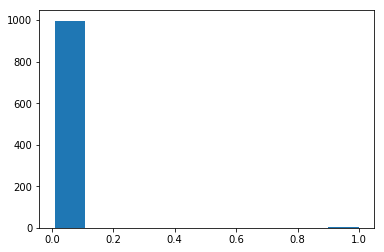

In [14]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

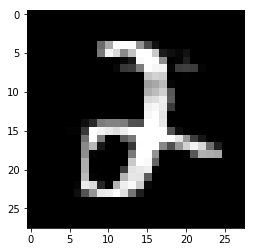

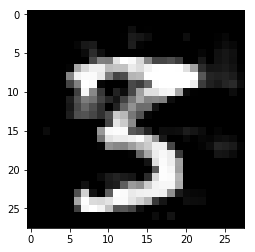

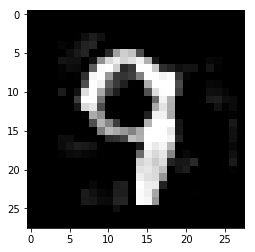

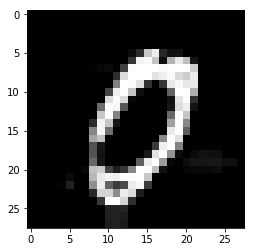

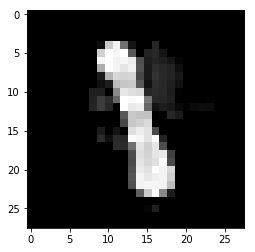

In [15]:
for i in range(5):
    plt.imshow(x_adv[i + 990].cpu().detach().numpy().squeeze(), cmap='gray')
    plt.show()

In [16]:
y_clean = dknn.classify(x_test[:1000])
ind = (y_clean.argmax(1) == y_test[:1000].numpy()) & (y_pred.argmax(1) != y_test[:1000].numpy())
np.mean(np.sqrt(np.sum((x_adv.cpu().detach().numpy()[ind] - x_test.numpy()[:1000][ind])**2, (1, 2, 3))))

2.1055484

## CW L2 Attack

without DkNN

In [ ]:
attack = CWL2Attack()

def attack_batch(x, y, batch_size):
    x_adv = torch.zeros_like(x)
    total_num = x.size(0)
    num_batches = total_num // batch_size
    for i in range(num_batches):
        begin = i * batch_size
        end = (i + 1) * batch_size
        x_adv[begin:end] = attack(
            net, x[begin:end], y[begin:end], targeted=False,
            binary_search_steps=5, max_iterations=500,
            confidence=0, learning_rate=1e-1,
            initial_const=1, abort_early=True)
    return x_adv

x_adv = attack_batch(x_test[:1000].cuda(), y_test[:1000].cuda(), 100)

In [273]:
y_pred = net(x_adv)
(y_pred.argmax(1).cpu() == y_test[:1000]).numpy().sum() / y_pred.size(0)

AttributeError: 'tuple' object has no attribute 'argmax'

In [274]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum() / len(y_pred)

0.702

(array([139.,  46.,  23.,  19.,   3.,   3.,   4.,   2.,   2.,   3.]),
 array([0.0165    , 0.08763333, 0.15876667, 0.2299    , 0.30103333,
        0.37216667, 0.4433    , 0.51443333, 0.58556667, 0.6567    ,
        0.72783333]),
 <a list of 10 Patch objects>)

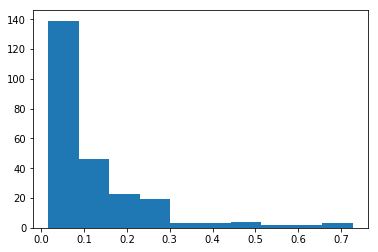

In [90]:
cred = dknn.credibility(y_pred)
suc_ind = y_pred.argmax(1) != y_test[:1000].numpy()
plt.hist(cred[suc_ind])

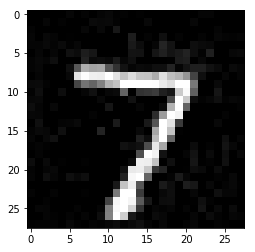

In [87]:
plt.imshow(x_adv[0].cpu().detach().numpy().squeeze(), cmap='gray')

In [88]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(0.7349, grad_fn=<MeanBackward1>)

---

In [27]:
# Set all random seeds
exp_id = 0
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'train_mnist_cav_exp%d.h5' % exp_id
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = ClassAuxVAE((1, 28, 28), num_classes=10, latent_dim=20)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
net = net.module
net.eval()

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [32]:
x_train = x_train.to(device)
x_test = x_test.to(device)
x_valid = x_valid.to(device)

In [28]:
net

ClassAuxVAE(
  (en_conv1): Conv2d(1, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace)
  (en_conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3))
  (relu2): ReLU(inplace)
  (en_conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace)
  (en_fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU(inplace)
  (en_mu): Linear(in_features=128, out_features=20, bias=True)
  (en_logvar): Linear(in_features=128, out_features=20, bias=True)
  (de_fc1): Linear(in_features=20, out_features=128, bias=True)
  (de_fc2): Linear(in_features=128, out_features=1568, bias=True)
  (ax_fc1): Linear(in_features=20, out_features=128, bias=True)
  (ax_fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [59]:
layers = ['en_mu']
net = net.to(device)
with torch.no_grad():
    dknn = DKNN(net, x_train, y_train, x_valid, y_valid, layers, 
                k=10, num_classes=10)
    y_pred = dknn.classify(x_test)

In [60]:
(y_pred.argmax(1) == y_test.numpy()).sum() / y_test.size(0)

0.964

(array([ 741., 1243.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8016.]),
 array([0.01683333, 0.11515   , 0.21346667, 0.31178333, 0.4101    ,
        0.50841667, 0.60673333, 0.70505   , 0.80336667, 0.90168333,
        1.        ]),
 <a list of 10 Patch objects>)

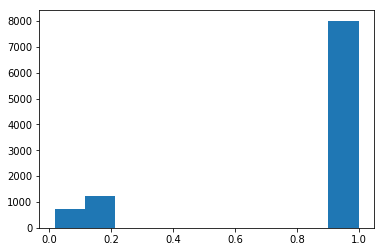

In [61]:
cred = dknn.credibility(y_pred)
plt.hist(cred)

In [62]:
from lib.dknn_attack import DKNNAttack

attack = DKNNAttack()
x_adv = attack(dknn, x_test[:1000], y_test[:1000],
               guide_layer='en_mu', binary_search_steps=5,
               max_iterations=500, learning_rate=1e-1,
               initial_const=1, abort_early=True)

    step: 0; loss: -10.374; l2dist: 0.000
    step: 50; loss: -16.516; l2dist: 2.206
    step: 100; loss: -17.532; l2dist: 2.233
    step: 150; loss: -21.379; l2dist: 2.383
    step: 200; loss: -23.950; l2dist: 2.461
    step: 250; loss: -25.525; l2dist: 2.522
    step: 300; loss: -26.562; l2dist: 2.575
    step: 350; loss: -27.237; l2dist: 2.610
    step: 400; loss: -27.690; l2dist: 2.641
    step: 450; loss: -27.980; l2dist: 2.662
binary step: 0; number of successful adv: 732/1000
    step: 0; loss: -31.082; l2dist: 0.000
    step: 50; loss: -80.035; l2dist: 2.555
    step: 100; loss: -102.080; l2dist: 2.891
    step: 150; loss: -113.852; l2dist: 3.048
    step: 200; loss: -119.545; l2dist: 3.074
    step: 250; loss: -122.952; l2dist: 3.069
    step: 300; loss: -125.118; l2dist: 3.057
    step: 350; loss: -126.465; l2dist: 3.052
    step: 400; loss: -127.398; l2dist: 3.048
    step: 450; loss: -127.963; l2dist: 3.048
binary step: 1; number of successful adv: 1000/1000
    step: 0; lo

In [18]:
y_pred = dknn.classify(x_adv)
(y_pred.argmax(1) == y_test[:1000].numpy()).sum()

0

In [40]:
x.size()

torch.Size([1000, 128, 4, 4])

In [41]:
F.normalize(x.view(1000, -1), 2, 1).norm(2, 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

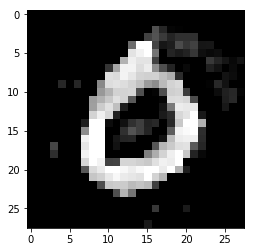

In [56]:
plt.imshow(x_adv[3].cpu().detach().numpy().squeeze(), cmap='gray')

In [20]:
(x_adv.cpu() - x_test[:1000]).view(1000, -1).norm(dim=0).mean()

tensor(1.9813, grad_fn=<MeanBackward1>)

---
# Soft DkNN

In [ ]:
def attack_soft_dknn(dknn, x):
    
    train_reps = dknn.get_activations(dknn.x_train)[dknn.layers[0]]
    dknn.model

In [14]:
with torch.no_grad():
    train_reps = dknn.get_activations(dknn.x_train)[dknn.layers[0]]
    train_reps = F.normalize(train_reps.view(dknn.x_train.size(0), -1), 2, 1)
    test_reps = dknn.get_activations(x_test)[dknn.layers[0]]
    test_reps = F.normalize(test_reps.view(x_test.size(0), -1), 2, 1)

In [7]:
temp = 2e-2
k = 75

with torch.no_grad():
    logits = torch.empty((x_test.size(0), dknn.num_classes))
    for i, tr in enumerate(test_reps):
        cos = ((tr.unsqueeze(0) * train_reps).sum(1) / temp).exp()
#         cos = (tr.unsqueeze(0) * train_reps).sum(1)
        for label in range(dknn.num_classes):
#             logits[i, label] = cos[dknn.y_train == label].topk(k)[0].mean()
            logits[i, label] = cos[dknn.y_train == label].mean()

NameError: name 'test_reps' is not defined

---

## LID & Sensitivity

In [6]:
# spectral norm of jacobian and LID of basic model

layers = ['relu1', 'relu2', 'relu3', 'fc']
dknn = DKNNL2(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
              k=75, num_classes=10)

In [7]:
x = x_test.requires_grad_(True)[:1000]

In [8]:
norms = compute_spnorm(x, dknn, layers)
print(', '.join('%.4f' % i for i in norms.mean(0)))

3.5763, 12.8764, 26.2434, 13.5448


In [9]:
lid = np.zeros((x.size(0), len(layers)))
reps = dknn.get_activations(x, requires_grad=False)
train_reps = dknn.get_activations(x_train, requires_grad=False)

for l, layer in enumerate(layers):
    lid[:, l] = compute_lid(reps[layer], 
                         train_reps[layer], 
                         3000, 
                         exclude_self=False)
print(', '.join('%.4f' % i for i in lid.mean(0)))

12.5957, 11.1405, 8.5105, 4.0548


In [ ]:
# (maybe) spectral norm is not good for comparing between layers
# because of difference in dimension

In [6]:
# spectral norm of jacobian and LID of VAE (exp4)

layers = ['relu1', 'relu2', 'relu3', 'en_mu']
dknn = DKNNL2(net, x_train.cuda(), y_train, x_valid.cuda(), y_valid, layers, 
              k=75, num_classes=10)

In [ ]:
x = x_test.requires_grad_(True)[:1000]

In [ ]:
norms = compute_spnorm(x, dknn, layers)
print(', '.join('%.4f' % i for i in norms.mean(0)))

In [ ]:
lid = np.zeros((x.size(0), len(layers)))
reps = dknn.get_activations(x, requires_grad=False)
train_reps = dknn.get_activations(x_train, requires_grad=False)

for l, layer in enumerate(layers):
    lid[:, l] = compute_lid(reps[layer], 
                         train_reps[layer], 
                         3000, 
                         exclude_self=False)
print(', '.join('%.4f' % i for i in lid.mean(0)))